# Import packages & functions

In [ ]:
import os
import sys
import json
import argparse
import numpy as np
import math
from einops import rearrange
import time
import random
import string
import h5py
from tqdm import tqdm
import webdataset as wds
import gc

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torchvision import transforms
from accelerate import Accelerator

# tf32 data type is faster than standard float32
torch.backends.cuda.matmul.allow_tf32 = True

import sys
import os

# This gets you from /src/data → /src
src_path = os.path.abspath(os.getcwd())
sys.path.append(src_path)

# Now you can import the full path as a package
from generative_models.sgm.modules.encoders.modules import FrozenOpenCLIPImageEmbedder

/opt/conda/envs/fmri/lib/python3.10/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


In [2]:
# %%
### Multi-GPU config ###
local_rank = os.getenv('RANK')
if local_rank is None:
    local_rank = 0
else:
    local_rank = int(local_rank)
print("LOCAL RANK ", local_rank)

data_type = torch.float32 # change depending on your mixed_precision
accelerator = Accelerator(split_batches=False, mixed_precision="fp16") # ['no', 'fp8', 'fp16', 'bf16']
batch_size = 128
print("batch_size",batch_size)

LOCAL RANK  0
batch_size 128


In [3]:
print("PID of this process =",os.getpid())
device = accelerator.device
print("device:",device)
world_size = accelerator.state.num_processes
distributed = not accelerator.state.distributed_type == 'NO'
num_devices = torch.cuda.device_count()
if num_devices==0 or not distributed: num_devices = 1
num_workers = num_devices
print(accelerator.state)

# set data_type to match your mixed precision (automatically set based on deepspeed config)
if accelerator.mixed_precision == "bf16":
    data_type = torch.bfloat16
elif accelerator.mixed_precision == "fp16":
    data_type = torch.float16
else:
    data_type = torch.float32

print("distributed =",distributed, "num_devices =", num_devices, "local rank =", local_rank, "world size =", world_size, "data_type =", data_type)
print = accelerator.print # only print if local_rank=0

PID of this process = 1215580
device: cuda
Distributed environment: NO
Num processes: 1
Process index: 0
Local process index: 0
Device: cuda

Mixed precision type: fp16

distributed = False num_devices = 1 local rank = 0 world size = 1 data_type = torch.float16


# Configurations

In [4]:
# Load COCO images and captions
f = h5py.File(f'{os.getcwd()}/coco_images_224_float16.hdf5', 'r')
coco_images = f['images']#[:]
print("coco_images", coco_images.shape)

# coco_ids = np.load("trainval_coco_ids.npy")
# print("coco_ids", len(coco_ids))
# captions_dict = dict(np.load("trainval_coco_captions_dict.npy", allow_pickle=True).item())

coco_images (73000, 3, 224, 224)


### CLIP image embeddings  model

In [5]:
clip_img_embedder = FrozenOpenCLIPImageEmbedder(
    arch="ViT-B-32",
    version="openai",
    output_tokens=True,
    only_tokens=True,
)
clip_img_embedder.to(device)

clip_seq_dim = 49  
clip_emb_dim = 768

/opt/conda/envs/fmri/lib/python3.10/site-packages/huggingface_hub/file_download.py:896: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/opt/conda/envs/fmri/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


a man is in the air on a surfboard.


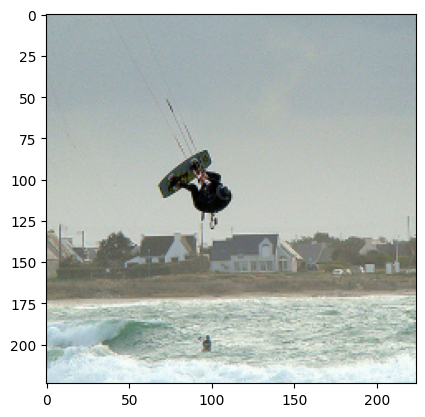

In [6]:
from transformers import AutoProcessor, AutoModelForCausalLM
from modeling_git import GitForCausalLMClipEmb


torch.cuda.empty_cache()
gc.collect()

processor = AutoProcessor.from_pretrained("microsoft/git-base-coco")
clip_text_model = GitForCausalLMClipEmb.from_pretrained("microsoft/git-base-coco", device_map='cpu')
clip_text_model.to(device)
clip_text_model.eval().requires_grad_(False)

image = torch.Tensor(coco_images[:1]).to(device)
plt.imshow(transforms.ToPILImage()(image[0]))

pixel_values = processor(images=image, return_tensors="pt", do_rescale=False).pixel_values.to(device)
image_features = clip_text_model.git.image_encoder(pixel_values).last_hidden_state
generated_ids = clip_text_model.generate(pixel_values=image_features, max_length=20)
generated_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
print(generated_caption)
clip_text_seq_dim = image_features.shape[1] #257
clip_text_emb_dim = image_features.shape[2] #1024
# annots = np.load("/fsx/proj-fmri/shared/mindeyev2_dataset/COCO_73k_annots_curated.npy")

### MindEye modules

In [7]:
class BigG_to_L(torch.nn.Module):
    def __init__(self):
        super(BigG_to_L, self).__init__()
        self.linear1 = nn.Linear(clip_seq_dim, clip_text_seq_dim)
        self.linear2 = nn.Linear(clip_emb_dim, clip_text_emb_dim)
    def forward(self, x):
        x = x.permute(0,2,1)
        x = self.linear1(x)
        x = self.linear2(x.permute(0,2,1))
        return x

# class RidgeRegression(torch.nn.Module):
#     def __init__(self):
#         super(RidgeRegression, self).__init__()
#         self.linear1 = nn.Sequential(
#                     nn.Linear(clip_seq_dim, clip_text_seq_dim),
#                     nn.LayerNorm(clip_text_seq_dim),
#                     nn.GELU(),
#                     nn.Dropout(0.15))
#         self.linear2 = nn.Sequential(
#                     nn.Linear(clip_emb_dim, clip_text_emb_dim),
#                     nn.LayerNorm(clip_text_emb_dim),
#                     nn.GELU(),
#                     nn.Dropout(0.15))
#     def forward(self, x):
#         x = x.permute(0,2,1)
#         x = self.linear1(x)
#         x = self.linear2(x.permute(0,2,1))
#         return x
        
model = BigG_to_L()

def count_params(model):
    total = sum(p.numel() for p in model.parameters())
    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print('param counts:\n{:,} total\n{:,} trainable'.format(total, trainable))
    return trainable
count_params(model)

# test on fake data
b = torch.randn((2,clip_seq_dim,clip_emb_dim))
print(b.shape)
print(model(b).shape)

param counts:
600,442 total
600,442 trainable
torch.Size([2, 49, 768])
torch.Size([2, 197, 768])


In [8]:
no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']

# opt_grouped_parameters = [
#     {'params': [p for n, p in model.named_parameters()], 'weight_decay': 1e-2},
# ]

opt_grouped_parameters = [
     {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 1e-2},
     {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0},   
]

max_lr = 3e-4
optimizer = torch.optim.AdamW(opt_grouped_parameters, lr=max_lr)

num_epochs = 150
total_steps=int(np.floor(num_epochs*len(coco_images)//batch_size))
print("total_steps", total_steps)
lr_scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer, 
    max_lr=max_lr,
    total_steps=total_steps,
    final_div_factor=1000,
    last_epoch=-1, pct_start=2/num_epochs
)

# Change from absolute teamspace path to workspace-relative path
CACHE_DIR = os.path.join(os.getcwd(), "cache")  # Creates 'cache' in current directory
# Or use the src path you already defined
# CACHE_DIR = os.path.join(src_path, "cache")  # Creates 'cache' in src directory
os.makedirs(CACHE_DIR, exist_ok=True)
print(f"Cache directory created at: {CACHE_DIR}")
# ──────────────────────────────────────────────────────────────────────────────


def save_ckpt(tag: str):
    # Ensure only the main process saves the checkpoint
    if accelerator.is_main_process:
        ckpt_path = os.path.join(CACHE_DIR, f"{tag}.pth")
        print(f"\nRank {local_rank} attempting to save checkpoint to {ckpt_path}...") # Added rank for debug
        try:
            unwrapped = accelerator.unwrap_model(model)
            torch.save({"model_state_dict": unwrapped.state_dict()}, ckpt_path)
            # Optional: Verify file exists immediately after save
            if os.path.exists(ckpt_path):
                 print(f"\nRank {local_rank} successfully saved and verified checkpoint → {ckpt_path}\n")
            else:
                 print(f"\nRank {local_rank} WARNING: torch.save completed but file not found at {ckpt_path}!\n")
            del unwrapped # Keep this cleanup
        except Exception as e:
             print(f"\nRank {local_rank} ERROR saving checkpoint to {ckpt_path}: {e}\n") # Add error catching


def load_ckpt(tag: str, strict: bool = True):
    ckpt_path = os.path.join(CACHE_DIR, f"{tag}.pth")          # ← load from cache
    print(f"\n— loading checkpoint ← {ckpt_path}\n")
    state_dict = torch.load(ckpt_path, map_location="cpu")["model_state_dict"]
    try:
        model.module.load_state_dict(state_dict, strict=strict)
    except AttributeError:                                     # not wrapped
        model.load_state_dict(state_dict, strict=strict)
    del state_dict
        
print("\nDone with model preparations!")
num_params = count_params(model)

total_steps 85546
Cache directory created at: /workspace/MindEyeV2/MindEyeV2/src/data/cache

Done with model preparations!
param counts:
600,442 total
600,442 trainable


# Main

In [23]:
epoch = 8
losses, test_losses, lrs = [], [], []
torch.cuda.empty_cache()

In [24]:
# load saved ckpt model weights into current model
load_ckpt("epoch8")


— loading checkpoint ← /workspace/MindEyeV2/MindEyeV2/src/data/cache/epoch8.pth



In [25]:
model, optimizer, lr_scheduler = accelerator.prepare(model, optimizer, lr_scheduler)

In [26]:
print(f"Starting with epoch {epoch} / {num_epochs}")
progress_bar = tqdm(range(epoch,num_epochs), ncols=600, disable=(local_rank!=0))
mse = nn.MSELoss()

for epoch in progress_bar:
    print(f"Epoch {epoch+1} of {num_epochs}")
    model.train()
    for iteration in range(100): #tqdm(range(len(coco_images)//batch_size)):
        with torch.cuda.amp.autocast(dtype=data_type):
            batch = np.random.choice(np.arange(1,len(coco_images)), size=batch_size, replace=False)
            optimizer.zero_grad()

            image = torch.Tensor(coco_images[np.sort(batch)]).to(device)
            
            bigG_input = clip_img_embedder(image)
            
            pixel_values = processor(images=image, return_tensors="pt", do_rescale=False).pixel_values.to(device)
            target = clip_text_model.git.image_encoder(pixel_values).last_hidden_state#.flatten(1)

            pred = model(bigG_input)
            loss = mse(pred, target)

            accelerator.backward(loss)
            optimizer.step()

            losses.append(loss.item())
            lrs.append(optimizer.param_groups[0]['lr'])
            lr_scheduler.step()

    model.eval()
    with torch.no_grad(), torch.cuda.amp.autocast(dtype=data_type):
        batch = np.arange(1)

        image = torch.Tensor(coco_images[np.sort(batch)]).to(device)
        
        bigG_input = clip_img_embedder(image)
        
        pixel_values = processor(images=image, return_tensors="pt", do_rescale=False).pixel_values.to(device)
        target = clip_text_model.git.image_encoder(pixel_values).last_hidden_state#.flatten(1)

        pred = model(bigG_input)
        loss = mse(pred, target)

        print("----")
        generated_ids = clip_text_model.generate(pixel_values=target.reshape(len(target),clip_text_seq_dim,clip_text_emb_dim), max_length=20)
        generated_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
        print(generated_caption)

        generated_ids = clip_text_model.generate(pixel_values=pred.reshape(len(pred),clip_text_seq_dim,clip_text_emb_dim), max_length=20)
        generated_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
        print(generated_caption)

        print("loss", loss.item())

    # wait for other GPUs to catch up if needed
    accelerator.wait_for_everyone()
    torch.cuda.empty_cache()
    gc.collect()
    
    # if (epoch % 20)==0 or epoch>0: #previous: and 
        # print("SAVED CKPT")
    save_ckpt(f"epoch{epoch}")

print("saving...")
save_ckpt(f"epoch{epoch}")

print("\n===Finished!===\n")
#loss 0.68847

Starting with epoch 8 / 150


  0%|                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           | 0/142 [00:00<?, ?it/s]

Epoch 9 of 150
----
a man is in the air on a surfboard.
a beach with a lot of people in the background.
loss 0.5496344566345215


  1%|███▉                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            | 1/142 [02:36<6:07:16, 156.29s/it]


Rank 0 attempting to save checkpoint to /workspace/MindEyeV2/MindEyeV2/src/data/cache/epoch8.pth...

Rank 0 successfully saved and verified checkpoint → /workspace/MindEyeV2/MindEyeV2/src/data/cache/epoch8.pth

Epoch 10 of 150
----
a man is in the air on a surfboard.
a beach with a lot of people in the background.
loss 0.5494001507759094


  1%|███████▉                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        | 2/142 [05:10<6:01:10, 154.79s/it]


Rank 0 attempting to save checkpoint to /workspace/MindEyeV2/MindEyeV2/src/data/cache/epoch9.pth...

Rank 0 successfully saved and verified checkpoint → /workspace/MindEyeV2/MindEyeV2/src/data/cache/epoch9.pth

Epoch 11 of 150
----
a man is in the air on a surfboard.
a beach with a lot of people in the background.
loss 0.5491662621498108


  2%|███████████▊                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    | 3/142 [07:51<6:05:53, 157.94s/it]


Rank 0 attempting to save checkpoint to /workspace/MindEyeV2/MindEyeV2/src/data/cache/epoch10.pth...

Rank 0 successfully saved and verified checkpoint → /workspace/MindEyeV2/MindEyeV2/src/data/cache/epoch10.pth

Epoch 12 of 150
----
a man is in the air on a surfboard.
a beach with a lot of people in the background.
loss 0.5492442846298218


  3%|███████████████▊                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                | 4/142 [10:26<6:00:08, 156.58s/it]


Rank 0 attempting to save checkpoint to /workspace/MindEyeV2/MindEyeV2/src/data/cache/epoch11.pth...

Rank 0 successfully saved and verified checkpoint → /workspace/MindEyeV2/MindEyeV2/src/data/cache/epoch11.pth

Epoch 13 of 150
----
a man is in the air on a surfboard.
a beach with a lot of people in the background.
loss 0.5491759777069092


  4%|███████████████████▋                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            | 5/142 [13:02<5:57:26, 156.55s/it]


Rank 0 attempting to save checkpoint to /workspace/MindEyeV2/MindEyeV2/src/data/cache/epoch12.pth...

Rank 0 successfully saved and verified checkpoint → /workspace/MindEyeV2/MindEyeV2/src/data/cache/epoch12.pth

Epoch 14 of 150
----
a man is in the air on a surfboard.
a beach with a lot of people in the background.
loss 0.5493322014808655


  4%|███████████████████████▋                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        | 6/142 [15:37<5:53:20, 155.89s/it]


Rank 0 attempting to save checkpoint to /workspace/MindEyeV2/MindEyeV2/src/data/cache/epoch13.pth...

Rank 0 successfully saved and verified checkpoint → /workspace/MindEyeV2/MindEyeV2/src/data/cache/epoch13.pth

Epoch 15 of 150
----
a man is in the air on a surfboard.
a beach with a lot of people in the background.
loss 0.5492798686027527


  5%|███████████████████████████▌                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    | 7/142 [18:10<5:48:53, 155.06s/it]


Rank 0 attempting to save checkpoint to /workspace/MindEyeV2/MindEyeV2/src/data/cache/epoch14.pth...

Rank 0 successfully saved and verified checkpoint → /workspace/MindEyeV2/MindEyeV2/src/data/cache/epoch14.pth

Epoch 16 of 150


  5%|███████████████████████████▌                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    | 7/142 [18:13<5:51:28, 156.21s/it]


OutOfMemoryError: CUDA out of memory. Tried to allocate 148.00 MiB. GPU 0 has a total capacty of 21.95 GiB of which 141.88 MiB is free. Process 1179407 has 2.04 GiB memory in use. Including non-PyTorch memory, this process has 3.10 GiB memory in use. Process 1304273 has 16.65 GiB memory in use. Of the allocated memory 2.05 GiB is allocated by PyTorch, and 243.46 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF